# Bias Buccaneers Image Recognition Challenge: Quickstart

This notebook will introduce you to the data and describe a workflow to train and evaluate a baseline model on it.

## Initial Setup

We start with loading the required packages.

In [1]:
# !pip install tensorflow
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Specify the Model

We define a single model class that is able train on the data in `X` and `Y` and predict outcomes for all three classes.

### Custom Metrics

In [3]:
class CategoricalDisparity(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="disparity", **kwargs):
        super(CategoricalDisparity, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        if (K.backend.int_shape(new_cm) == (self.num_classes, self.num_classes)) and (self.num_classes > 0):
            self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_max - self.acc_min
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalDisparity, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
class CategoricalDisparityScore(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="disparity_score", **kwargs):
        super(CategoricalDisparityScore, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")
        self.score = self.add_weight(name="score", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        if (K.backend.int_shape(new_cm) == (self.num_classes, self.num_classes)) and (self.num_classes > 0):
            self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        acc = K.backend.sum(diag)/K.backend.sum(self.cm)

        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
        if (self.num_classes == 2):
          weight = 2
          penalty = 1
        elif (self.num_classes== 10):
          weight = 10
          penalty = 5
        else: 
          weight = 4
          penalty = 2

        self.score.assign(weight * acc * (1 - (self.acc_max - self.acc_min)**penalty))

    def result(self):
        return self.score
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.score.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalDisparityScore, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
class CategoricalMaxAccuracy(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="max_accuracy", **kwargs):
        super(CategoricalMaxAccuracy, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        if (K.backend.int_shape(new_cm) == (self.num_classes, self.num_classes)) and (self.num_classes > 0):
            self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_max
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalMaxAccuracy, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
class CategoricalMinAccuracy(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="min_accuracy", **kwargs):
        super(CategoricalMinAccuracy, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes    

        self.acc_max = self.add_weight(name="max", initializer="zeros")
        self.acc_min = self.add_weight(name="min", initializer="zeros")

        self.cm = self.add_weight(name="cm", shape=[num_classes,num_classes], initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.backend.argmax(y_true, axis=-1)
        y_pred = K.backend.argmax(y_pred, axis=-1)
        y_true = K.backend.flatten(y_true)

        new_cm = tf.math.confusion_matrix(y_true,y_pred, num_classes = self.num_classes, dtype=tf.float32)
        
        self.cm.assign_add(new_cm)
        row_sum = K.backend.sum(self.cm, axis=0)
        diag = K.backend.cast(tf.linalg.diag_part(self.cm), dtype=tf.float32)
        accuracies = diag / row_sum
        acc_max = K.backend.max(accuracies)
        acc_min = K.backend.min(accuracies)
        
        self.acc_max.assign(acc_max)
        self.acc_min.assign(acc_min)
        
    def result(self):
        return self.acc_min
    
    def reset_state(self):
        self.acc_max.assign(0)
        self.acc_min.assign(0)
        self.cm.assign(np.zeros([self.num_classes, self.num_classes], dtype=np.float32))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(CategoricalMinAccuracy, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
class PredictionModel():
    def __init__(self):
        self.models = [None]*3
        self.face_model = [None]

    def load(self, folder='/content/drive/MyDrive/face_bounty/models/', paths=['skin_tone.h5','gender.h5','age.h5'], face_path='face_detect.h5'):
        custom_objects={"CategoricalDisparity": CategoricalDisparity,
                  "CategoricalDisparityScore": CategoricalDisparityScore,
                  "CategoricalMinAccuracy": CategoricalMinAccuracy,
                  "CategoricalMaxAccuracy": CategoricalMaxAccuracy,
                  }
        for i in range(3):
           self.models[i] = K.models.load_model(folder+paths[i], custom_objects=custom_objects)

        self.face_model[0] = K.models.load_model(folder+face_path)

        
    def predict(self, newX):
        face_detect = self.face_model[0].predict(newX)
        faces = np.argmax(face_detect,axis=1)
        predictions = [np.argmax(model.predict(newX),axis=1) for model in self.models]
        num_classes = [10,2,4]
        clean_preds = []
        for i in range(3):
          clean_preds.append([np.random.randint(num_classes[i]) if (faces[j] == 0) else predictions[i][j] for j in range(predictions[i].shape[0])])
        return clean_preds

## Reload Model from Saved File


In [13]:
loadmodel = PredictionModel()

In [14]:
loadmodel.load(folder = '/content/drive/MyDrive/face_bounty/models/')

## Evaluate the Model

We now evaluate the model on the test data. To do this, let's first load up that data and structure it similarly.

In [19]:
# load labels data
TESTPATH = './test/'
df_test = pd.read_csv(TESTPATH+'labels.csv')

cat = ['skin_tone','gender','age']
lbs = [LabelBinarizer() for i in range(3)]

length = width = 64

# Convert labels to np array
print("Converting test labels to np array")
testY = []
for i in range(3):
    lab = lbs[i].fit_transform(df_test[cat[i]])
    if lab.shape[1]==1:
        testY.append(np.hstack((1-lab,lab)))
    else:
        testY.append(lab)
        
# load and convert images into np array
print("Loading test images")
nt = df_test.shape[0]
all_imgs = [image.load_img(TESTPATH+df_test.iloc[i]['name'], target_size=(length,width)) for i in range(nt)]

print("Converting test images to np array")
testX = np.empty([nt, length, width, 3], dtype=float)
for i in range(nt):
    testX[i,:] = image.img_to_array(all_imgs[i])
testX = K.applications.resnet50.preprocess_input(testX)

Converting test labels to np array
Loading test images
Converting test images to np array


In [20]:
face_indices = df_test['real_face'][:1000] == 1
fake_indices = df_test['real_face'][:1000] != 1

Next we predict the test data

In [22]:
preds = loadmodel.predict(testX)

94/94 [==============================] - 3s 16ms/step


In [23]:
predLabels = [[lbs[i].classes_[j] for j in preds[i]] for i in range(3)]

Finally, we calculate the label-wise accuracy and disparity.

In [24]:
# calculate accuracy
acc = {}
for i in range(3):
    icat = cat[i]
    iacc = accuracy_score(df_test[cat[i]], predLabels[i])
    acc[icat] = iacc
    
# calculate disparity
def disparity_score(ytrue, ypred):
    cm = confusion_matrix(ytrue,ypred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    all_acc = list(cm.diagonal())
    return max(all_acc) - min(all_acc)

disp = {}
for i in range(3):
    icat = cat[i]
    idisp = disparity_score(df_test[cat[i]], predLabels[i])
    disp[icat] = idisp
disp

results = {'accuracy': acc, 'disparity': disp}
results

{'accuracy': {'skin_tone': 0.22533333333333333,
  'gender': 0.7523333333333333,
  'age': 0.5546666666666666},
 'disparity': {'skin_tone': 0.22036391792489352,
  'gender': 0.09417303065174187,
  'age': 0.3951245763691837}}

In [30]:
import scipy.stats as stats

true_acc = {}
true_disp = {}
for i in range(3):
    icat = cat[i]
    iacc = accuracy_score(df_test[:1000][face_indices.values][cat[i]], np.array(predLabels[i])[:1000][face_indices.values])
    idisp = disparity_score(df_test[:1000][face_indices.values][cat[i]], np.array(predLabels[i])[:1000][face_indices.values])
    true_acc[icat] = iacc
    true_disp[icat] = idisp


fake_acc = {}
for i in range(3):
    icat = cat[i]
    obs = pd.Series(predLabels[i][:1000])[fake_indices.values].value_counts().values
    e = obs.sum()/len(obs)
    chi2 = ((obs - e)**2 / e).sum()
    iacc = 1 - stats.chi2.cdf(chi2, df=len(obs)-1)
    fake_acc[icat] = iacc

true_results = {'accuracy': true_acc, 'disparity': true_disp, 'chi_square': fake_acc}


In [33]:
print(true_results)

{'accuracy': {'skin_tone': 0.2605140186915888, 'gender': 0.830607476635514, 'age': 0.625}, 'disparity': {'skin_tone': 0.2346610588817417, 'gender': 0.1157741913701128, 'age': 0.3774009858915519}, 'chi_square': {'skin_tone': 0.27570893677222197, 'gender': 0.8676323347781927, 'age': 0.16777400211514304}}


skin_tone


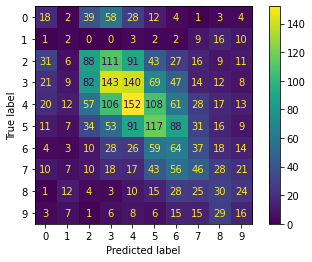

gender


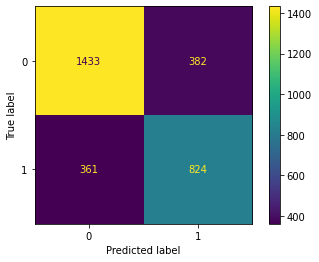

age


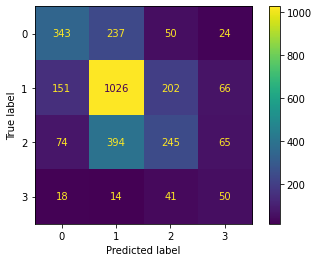

In [28]:
import matplotlib.pyplot as plt

for i in range(3):
    print(cat[i])
    ConfusionMatrixDisplay(confusion_matrix(df_test[cat[i]], predLabels[i])).plot()
    plt.show()

# Score Model and Prepare Submission

Based on the above metric, we now calculate the score to evaluate your submission. This score will be displayed in your public leaderboard.

In [32]:
def getScore(results):
    acc = results['accuracy']
    disp = results['disparity']
    ad = 2*acc['gender']*(1-disp['gender']) + 4*acc['age']*(1-disp['age']**2) + 10*acc['skin_tone']*(1-disp['skin_tone']**5)
    return ad

title = 'OIICrew'
    
submission = {
    'submission_name': title,
    'score': getScore(results),
    'metrics': results
}

   
submission

{'submission_name': 'OIICrew',
 'score': 5.487410872896863,
 'metrics': {'accuracy': {'skin_tone': 0.22533333333333333,
   'gender': 0.7523333333333333,
   'age': 0.5546666666666666},
  'disparity': {'skin_tone': 0.22036391792489352,
   'gender': 0.09417303065174187,
   'age': 0.3951245763691837}}}

In [35]:
getScore(true_results)

6.21609687564982

Finally, let's export this as a json file to upload as part of filling out your [submission form](https://docs.google.com/forms/d/e/1FAIpQLSfwqtVkJBVRP6TnFp7vHbbH8SlwKZJFIjvGQy7TyYFc8HR1hw/viewform).

In [ ]:
with open("model_score.json", "w") as f:
    json.dump(submission, f, indent=4)